In [277]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle
import sklearn as sk
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from munkres import Munkres
import pandas as pd
from ktools import *
import igraph as ig
import leidenalg
import tqdm

In [278]:
res = {}


In [279]:
label_colors = {"louvain":sns.color_palette()[0],
                "leiden": sns.color_palette()[1],
                "gn":sns.color_palette()[2]}

# Importing Data

Data Set

In [280]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A

In [281]:
#handling the edges
data = pd.read_csv(r"C:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code\data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()
df

,zero,one
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


In [282]:
# Handling the Labels
labels = pd.read_csv(r"C:\Users\Felipe Cintra\Documents\TUE_2324\JBG-100 BEP\Code\data\email-Eu-core-department-labels.txt.gz")

labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)
labels = pd.DataFrame({"node": to_integer(series_0), "label": to_integer(series_1)})
labels = labels.dropna()

In [283]:
comms = {label: list(labels[labels["label"] == label]["node"]) for label in labels["label"].unique()}
labels["community"] = labels["label"].map(comms)

In [284]:
A = create_adjacency(df)
eucore = nx.from_numpy_array(A)
nx.set_node_attributes(eucore, labels["community"], "community")
eucore.remove_node(1004)

Random Networks


In [285]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [286]:
np.random.set_state(import_random_state())

In [287]:
G_small = pickle.load(open('small50.pickle', 'rb'))

In [288]:
G_medium = pickle.load(open('medium250.pickle', 'rb'))

In [289]:
G_large = pickle.load(open('large250.pickle', 'rb'))

In [290]:
def create_gcl(G):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]

    return gcl

# Creating Baselines

### Baseline Louvain

In [291]:
def baseline_metrics_louvain(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [nx.community.louvain_communities(G) for _ in range(n)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(n):
        counter =0
        comms = nx.community.louvain_communities(G)
        comms = [frozenset(i) for i in comms]

        community_dict = {}
        for i in comms:
            if i not in community_dict:
                community_dict[i] = counter
            counter += 1

        lcl = []
        for node in G.nodes:
            c = [x for x in comms if node in x]
            c = c[0]
            lcl.append(community_dict[c])

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    return stats_dict

In [292]:
res["louvain_small"] =baseline_metrics_louvain(G_small)

In [293]:
res["louvain_medium"] = baseline_metrics_louvain(G_medium)

In [294]:
res["louvain_large"] = baseline_metrics_louvain(G_large)

In [295]:
res["louvain_eucore"] = baseline_metrics_louvain(eucore)

### Baseline Leiden

In [296]:
def run_leiden(G):
    """"Runs the Leidein Algorithm in a graph G"""
    h = ig.Graph.from_networkx(G)
    partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition)
    communities = [[] for _ in range(len(partition))]
    # Fill the communities with vertex indices
    for vertex, community in enumerate(partition.membership):
        communities[community].append(vertex)

    return communities    

In [297]:
def baseline_metrics_leiden(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [run_leiden(G) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []


    for _ in range(n):
        counter =0
        comms = run_leiden(G)
        comms = [frozenset(i) for i in comms]

        community_dict = {}
        for i in comms:
            if i not in community_dict:
                community_dict[i] = counter
            counter += 1

        lcl = []
        for node in G.nodes:
            c = [x for x in comms if node in x]
            c = c[0]
            lcl.append(community_dict[c])

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict



In [298]:
res["leiden_small"] = baseline_metrics_leiden(G_small)

In [299]:
res["leiden_medium"] = baseline_metrics_leiden(G_medium)

In [300]:
res["leiden_large"] = baseline_metrics_leiden(G_large)

In [301]:
res["leiden_eucore"] = baseline_metrics_leiden(eucore)

### Baseline GN

In [302]:
nx.community.girvan_newman(G_medium)
comp = nx.community.girvan_newman(G_large)
gn = tuple(sorted(c) for c in next(comp))

gn_communities = {frozenset(c) for c in tqdm.tqdm(gn)}

In [ ]:
def baseline_metrics_gn(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}
    
    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]
    
    nx.community.girvan_newman(G)
    comp = nx.community.girvan_newman(G)
    gn = tuple(sorted(c) for c in next(comp))

    generated_communities = [{frozenset(c) for c in gn}] 
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    
    comms = frozenset(generated_communities[0]) 
    counter = 0


    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

    #calculating kappa   
    l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict

In [ ]:
res["gn_small"] = baseline_metrics_gn(G_small)

In [ ]:
res["gn_medium"] = baseline_metrics_gn(G_medium)


In [ ]:
res["gn_large"] =  baseline_metrics_gn(G_medium)

In [ ]:
res["gn_eucore"] = baseline_metrics_gn(eucore)

In [ ]:
def flow_capacity_louvain(G:nx.Graph,T:list, step, n, quality)->list[set]:
    """Creates communities based on the flow capacity Louvain algorithm

    Args:
        G (nx.Graph): _description_
        T (list): _description_

    Returns:
        list[set]: _description_
    """ 

    # ----------------------------- generating_labels ---------------------------- #
    
    for tn in T:
        for alpha in np.arange(0, 1, 1/step):
            gcl = create_gcl(tn) 
            



In [ ]:
modularities = [res[key]["a_modularity"] for key in res ]

colors = [label_colors[str(key).split("_")[0]] for key in res]

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_26132\2601503625.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 1.0, 'Modularity of Baseline Implementations')

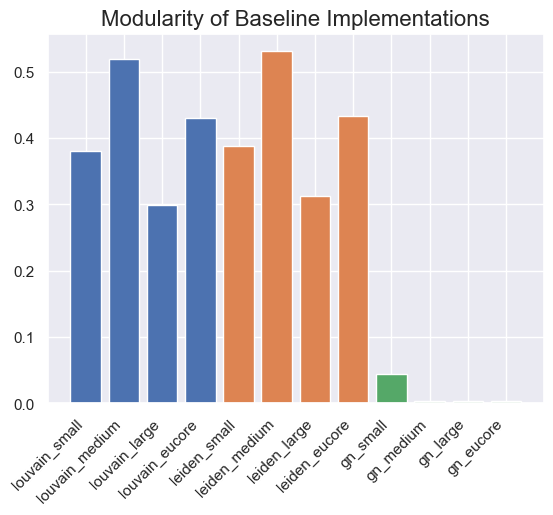

In [ ]:
fig, ax = plt.subplots()
ax.bar([key for key in res], modularities, color=colors)
ax.set_xticklabels(ax.get_xticklabels(),  rotation=45, horizontalalignment="right")
plt.title("Modularity of Baseline Implementations", fontsize=16)